In [2]:
import skimage.segmentation
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline


/usr/lib/python2.7/dist-packages/pkg_resources/__init__.py:1224: UserWarning: /home/brendan/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


In [3]:
#slic uses the l2 distance. 
def slic(img_arr, n,cpt=20):
    return skimage.segmentation.slic(img_arr,n,enforce_connectivity=True,compactness=cpt)
def const_y_arr(img_arr):
    x=img_arr.shape[0]
    y=img_arr.shape[1]
    arr=np.arange(x)
    arr=np.reshape(arr,(x,1,1))
    return np.repeat(arr,y,axis=1)
def const_x_arr(img_arr):
    x=img_arr.shape[0]
    y=img_arr.shape[1]
    arr=np.arange(y)
    arr=np.reshape(arr,(1,y,1))
    return np.repeat(arr,x,axis=0)
#     print(arr.shape)
#     print(np.repeat(,img_arr.shape[1],axis=0))


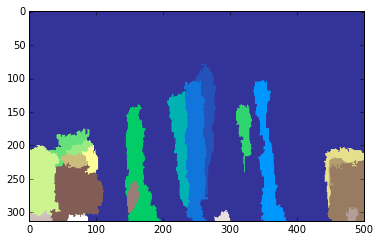

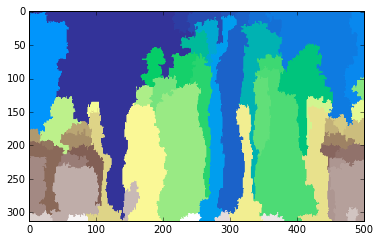

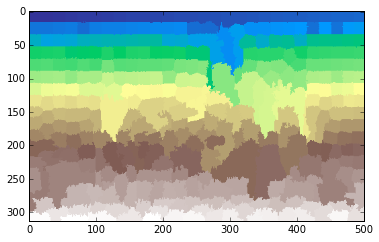

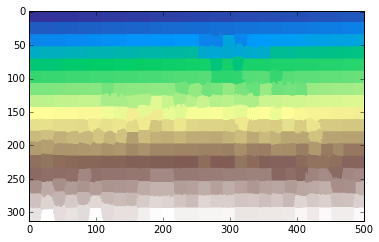

In [7]:
def with_spatial_feats(plot=True):
    img_arr=np.asarray(Image.open("Images/Q3/castle.jpg"),dtype=np.float64)/255.0

    ys=const_y_arr(img_arr)
    xs=const_x_arr(img_arr)
    #tried incorporating positional features but jsut gives a gradient
    img_stack=np.concatenate((img_arr,xs,ys),axis=2)

    new_arr=slic(img_stack,1000)
    mox=np.max(new_arr)
    new_arr=new_arr/float(mox)
    # print(new_arr.shape)
    if plot:
        plt.figure()
        plt.imshow(new_arr,cmap="Greys")  
    return new_arr

def no_spatial_feats(plot=True):
    img_arr=np.asarray(Image.open("Images/Q3/castle.jpg"),dtype=np.float64)/255.0
    new_arr=slic(img_arr,500)
    if plot:
        plt.figure()
        plt.imshow(new_arr,cmap="terrain")   
    return new_arr

#vary the wieght that controls the relationship between color similarity and spatial simmilarity
def lots_of_weights():
    img_arr=np.asarray(Image.open("Images/Q3/castle.jpg"),dtype=np.float64)/255.0
    for i in [0.1,1,10,100]:
        new_arr=slic(img_arr,500,i)
        plt.figure()
        plt.imshow(new_arr,cmap="terrain")
        
lots_of_weights()
# with_spatial_feats()



(1, 17, 28)


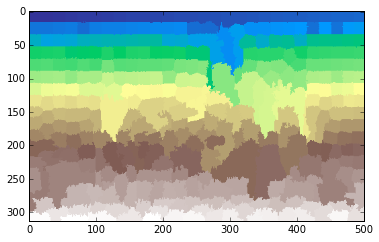

In [17]:
import collections as coll
from scipy import ndimage as ndi

# from skimage._shared.utils import warn
from skimage.util import img_as_float, regular_grid
from skimage.segmentation._slic import (_slic_cython,
                                  _enforce_label_connectivity_cython)
from skimage.color import rgb2lab

def lib_slic(image, n_segments=100, compactness=10., max_iter=10, sigma=0,
         spacing=None, multichannel=True, convert2lab=None,
         enforce_connectivity=True, min_size_factor=0.5, max_size_factor=3,
         slic_zero=False):    
    image = img_as_float(image)
    is_2d = False
    if image.ndim == 2:
        # 2D grayscale image
        image = image[np.newaxis, ..., np.newaxis]
        is_2d = True
    elif image.ndim == 3 and multichannel:
        # Make 2D multichannel image 3D with depth = 1
        image = image[np.newaxis, ...]
        is_2d = True
    elif image.ndim == 3 and not multichannel:
        # Add channel as single last dimension
        image = image[..., np.newaxis]

    if spacing is None:
        spacing = np.ones(3)
    elif isinstance(spacing, (list, tuple)):
        spacing = np.array(spacing, dtype=np.double)

    if not isinstance(sigma, coll.Iterable):
        sigma = np.array([sigma, sigma, sigma], dtype=np.double)
        sigma /= spacing.astype(np.double)
    elif isinstance(sigma, (list, tuple)):
        sigma = np.array(sigma, dtype=np.double)
    if (sigma > 0).any():
        # add zero smoothing for multichannel dimension
        sigma = list(sigma) + [0]
        image = ndi.gaussian_filter(image, sigma)

    if multichannel and (convert2lab or convert2lab is None):
        if image.shape[-1] != 3 and convert2lab:
            raise ValueError("Lab colorspace conversion requires a RGB image.")
        elif image.shape[-1] == 3:
            image = rgb2lab(image)

    depth, height, width = image.shape[:3]

    # initialize cluster centroids for desired number of segments
    grid_z, grid_y, grid_x = np.mgrid[:depth, :height, :width]
    slices = regular_grid(image.shape[:3], n_segments)
    step_z, step_y, step_x = [int(s.step if s.step is not None else 1)
                              for s in slices]
    segments_z = grid_z[slices]
    segments_y = grid_y[slices]
    segments_x = grid_x[slices]

    segments_color = np.zeros(segments_z.shape + (image.shape[3],))
    segments = np.concatenate([segments_z[..., np.newaxis],
                               segments_y[..., np.newaxis],
                               segments_x[..., np.newaxis],
                               segments_color],
                              axis=-1).reshape(-1, 3 + image.shape[3])
    segments = np.ascontiguousarray(segments)

    # we do the scaling of ratio in the same way as in the SLIC paper
    # so the values have the same meaning
    step = float(max((step_z, step_y, step_x)))
    ratio = 1.0 / compactness

    image = np.ascontiguousarray(image * ratio)

    labels = _slic_cython(image, segments, step, max_iter, spacing, slic_zero)

    if enforce_connectivity:
        segment_size = depth * height * width / n_segments
        min_size = int(min_size_factor * segment_size)
        max_size = int(max_size_factor * segment_size)
        labels = _enforce_label_connectivity_cython(labels,
                                                    n_segments,
                                                    min_size,
                                                    max_size)

    if is_2d:
        labels = labels[0]

    return {"labels":labels,"grid":segments_x}


img_arr=np.asarray(Image.open("Images/Q3/castle.jpg"),dtype=np.float64)/255.0
the_slic=lib_slic(img_arr,500)
new_arr=the_slic["labels"]
print(the_slic["grid"].shape)
plt.figure()
plt.imshow(new_arr,cmap="terrain")   


/home/brendan/.local/lib/python2.7/site-packages/ipykernel/__main__.py:97: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


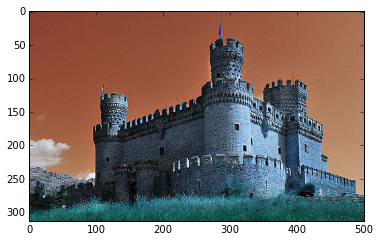

In [30]:
import sys
import cv2

class SLIC:
    def __init__(self, img, step, nc):
        self.img = img
        self.height, self.width = img.shape[:2]
        self._convertToLAB()
        self.step = step
        self.nc = nc
        self.ns = step
        self.FLT_MAX = 1000000
        self.ITERATIONS = 10

    def _convertToLAB(self):
        try:
            import cv2
            self.labimg = cv2.cvtColor(img, cv2.COLOR_BGR2LAB).astype(np.float64)
        except ImportError:
            self.labimg = np.copy(self.img)
            for i in xrange(self.labimg.shape[0]):
                for j in xrange(self.labimg.shape[1]):
                    rgb = self.labimg[i, j]
                    self.labimg[i, j] = self._rgb2lab(tuple(reversed(rgb)))

    def _rgb2lab ( self, inputColor ) :

       num = 0
       RGB = [0, 0, 0]

       for value in inputColor :
           value = float(value) / 255

           if value > 0.04045 :
               value = ( ( value + 0.055 ) / 1.055 ) ** 2.4
           else :
               value = value / 12.92

           RGB[num] = value * 100
           num = num + 1

       XYZ = [0, 0, 0,]

       X = RGB [0] * 0.4124 + RGB [1] * 0.3576 + RGB [2] * 0.1805
       Y = RGB [0] * 0.2126 + RGB [1] * 0.7152 + RGB [2] * 0.0722
       Z = RGB [0] * 0.0193 + RGB [1] * 0.1192 + RGB [2] * 0.9505
       XYZ[ 0 ] = round( X, 4 )
       XYZ[ 1 ] = round( Y, 4 )
       XYZ[ 2 ] = round( Z, 4 )

       XYZ[ 0 ] = float( XYZ[ 0 ] ) / 95.047         # ref_X =  95.047   Observer= 2°, Illuminant= D65
       XYZ[ 1 ] = float( XYZ[ 1 ] ) / 100.0          # ref_Y = 100.000
       XYZ[ 2 ] = float( XYZ[ 2 ] ) / 108.883        # ref_Z = 108.883

       num = 0
       for value in XYZ :

           if value > 0.008856 :
               value = value ** ( 0.3333333333333333 )
           else :
               value = ( 7.787 * value ) + ( 16 / 116 )

           XYZ[num] = value
           num = num + 1

       Lab = [0, 0, 0]

       L = ( 116 * XYZ[ 1 ] ) - 16
       a = 500 * ( XYZ[ 0 ] - XYZ[ 1 ] )
       b = 200 * ( XYZ[ 1 ] - XYZ[ 2 ] )

       Lab [ 0 ] = round( L, 4 )
       Lab [ 1 ] = round( a, 4 )
       Lab [ 2 ] = round( b, 4 )

       return Lab

    def generateSuperPixels(self):
        self._initData()
        indnp = np.mgrid[0:self.height,0:self.width].swapaxes(0,2).swapaxes(0,1)
        for i in range(self.ITERATIONS):
            self.distances = self.FLT_MAX * np.ones(self.img.shape[:2])
            for j in xrange(self.centers.shape[0]):
                xlow, xhigh = int(self.centers[j][3] - self.step), int(self.centers[j][3] + self.step)
                ylow, yhigh = int(self.centers[j][4] - self.step), int(self.centers[j][4] + self.step)

                if xlow <= 0:
                    xlow = 0
                if xhigh > self.width:
                    xhigh = self.width
                if ylow <=0:
                    ylow = 0
                if yhigh > self.height:
                    yhigh = self.height

                cropimg = self.labimg[ylow : yhigh , xlow : xhigh]
                colordiff = cropimg - self.labimg[self.centers[j][4], self.centers[j][3]]
                colorDist = np.sqrt(np.sum(np.square(colordiff), axis=2))

                yy, xx = np.ogrid[ylow : yhigh, xlow : xhigh]
                pixdist = ((yy-self.centers[j][4])**2 + (xx-self.centers[j][3])**2)**0.5
                dist = ((colorDist/self.nc)**2 + (pixdist/self.ns)**2)**0.5

                distanceCrop = self.distances[ylow : yhigh, xlow : xhigh]
                idx = dist < distanceCrop
                distanceCrop[idx] = dist[idx]
                self.distances[ylow : yhigh, xlow : xhigh] = distanceCrop
                self.clusters[ylow : yhigh, xlow : xhigh][idx] = j

            for k in xrange(len(self.centers)):
                idx = (self.clusters == k)
                colornp = self.labimg[idx]
                distnp = indnp[idx]
                self.centers[k][0:3] = np.sum(colornp, axis=0)
                sumy, sumx = np.sum(distnp, axis=0)
                self.centers[k][3:] = sumx, sumy
                self.centers[k] /= np.sum(idx)

    def _initData(self):
        self.clusters = -1 * np.ones(self.img.shape[:2])
        self.distances = self.FLT_MAX * np.ones(self.img.shape[:2])

        centers = []
        for i in xrange(self.step, self.width - self.step/2, self.step):
            for j in xrange(self.step, self.height - self.step/2, self.step):
                
                nc = self._findLocalMinimum(center=(i, j))
                color = self.labimg[nc[1], nc[0]]
                center = [color[0], color[1], color[2], nc[0], nc[1]]
                centers.append(center)
        self.center_counts = np.zeros(len(centers))
        self.centers = np.array(centers)

    def createConnectivity(self):
        label = 0
        adjlabel = 0
        lims = self.width * self.height / self.centers.shape[0]
        dx4 = [-1, 0, 1, 0]
        dy4 = [0, -1, 0, 1]
        new_clusters = -1 * np.ones(self.img.shape[:2]).astype(np.int64)
        elements = []
        for i in xrange(self.width):
            for j in xrange(self.height):
                if new_clusters[j, i] == -1:
                    elements = []
                    elements.append((j, i))
                    for dx, dy in zip(dx4, dy4):
                        x = elements[0][1] + dx
                        y = elements[0][0] + dy
                        if (x>=0 and x < self.width and 
                            y>=0 and y < self.height and 
                            new_clusters[y, x] >=0):
                            adjlabel = new_clusters[y, x]
                count = 1
                c = 0
                while c < count:
                    for dx, dy in zip(dx4, dy4):
                        x = elements[c][1] + dx
                        y = elements[c][0] + dy

                        if (x>=0 and x<self.width and y>=0 and y<self.height):
                            if new_clusters[y, x] == -1 and self.clusters[j, i] == self.clusters[y, x]:
                                elements.append((y, x))
                                new_clusters[y, x] = label
                                count+=1
                    c+=1
                if (count <= lims >> 2):
                    for c in range(count):
                        new_clusters[elements[c]] = adjlabel
                    label-=1
                label+=1
        self.new_clusters = new_clusters

    def displayContours(self, color):
        dx8 = [-1, -1, 0, 1, 1, 1, 0, -1]
        dy8 = [0, -1, -1, -1, 0, 1, 1, 1]

        isTaken = np.zeros(self.img.shape[:2], np.bool)
        contours = []

        for i in xrange(self.width):
            for j in xrange(self.height):
                nr_p = 0
                for dx, dy in zip(dx8, dy8):
                    x = i + dx
                    y = j + dy
                    if x>=0 and x < self.width and y>=0 and y < self.height:
                        if isTaken[y, x] == False and self.clusters[j, i] != self.clusters[y, x]:
                            nr_p += 1

                if nr_p >= 2:
                    isTaken[j, i] = True
                    contours.append([j, i])

        for i in xrange(len(contours)):
            self.img[contours[i][0], contours[i][1]] = color

    def _findLocalMinimum(self, center):
        min_grad = self.FLT_MAX
        loc_min = center
        for i in xrange(center[0] - 1, center[0] + 2):
            for j in xrange(center[1] - 1, center[1] + 2):
                c1 = self.labimg[j+1, i]
                c2 = self.labimg[j, i+1]
                c3 = self.labimg[j, i]
                if ((c1[0] - c3[0])**2)**0.5 + ((c2[0] - c3[0])**2)**0.5 < min_grad:
                    min_grad = abs(c1[0] - c3[0]) + abs(c2[0] - c3[0])
                    loc_min = [i, j]
        return loc_min

img = cv2.imread("Images/Q3/castle.jpg")
nr_superpixels = int(200)
nc = int(1000)

step = int((img.shape[0]*img.shape[1]/nr_superpixels)**0.5)

slic = SLIC(img, step, nc)
slic.generateSuperPixels()
slic.createConnectivity()
herp=slic.img
plt.imshow(herp)

# cv2.imshow("superpixels", slic.img)
# cv2.waitKey(0)
# cv2.imwrite("SLICimg.jpg", slic.img)